In [1]:
import pandas as pd
import boto3
import pickle
import yaml
import joblib

## 1. Function cargar_datos_s3
It receives as parameters the S3 bucket and the path where the file with the inspection data we want to check is located.

To know which file to download, the list_objects_v2 function of boto3 is used to identify the name of the stored pkl.

In [6]:
with open('credentials.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

bucket = 'aplicaciones-cd-1-' + config['iexe']['matricula']

def cargar_datos_s3(bucket):

    session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )    
    s3 = session.client('s3')
    key = s3.list_objects_v2(Bucket=bucket, Prefix="ingesta/inicial/")['Contents'][0]['Key']
    print(key)
    s3 = session.resource('s3')
    obj = s3.Object(bucket, key).get()['Body'].read()
    return obj


In [7]:
obj = cargar_datos_s3(bucket)

ingesta/inicial/inspecciones-historicas-2023-07-06.pkl


### Review the files that are in the bucket and save the path in key

In [48]:
session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )    
s3 = session.client('s3')
key = s3.list_objects_v2(Bucket=bucket, Prefix="ingesta/inicial/")['Contents'][1]['Key']
print(key)

ingesta/inicial/inspecciones-historicas-2023-07-06.pkl


## 2. Function transform_ing_ingesta
Receives as parameter the data downloaded from the S3 bucket.

Returns a data frame containing the records of the historical inspections that have been performed on food establishments in Chicago.

In [8]:
def transformar_ingesta(obj):
    df_load = pickle.loads(obj)
    return df_load

In [9]:
df = transformar_ingesta(obj)


In [10]:
df = pd.DataFrame(df)

In [11]:
df.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations
0,67732,WOLCOTT'S,TROQUET,1992039,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04T00:00:00.000,License Re-Inspection,Pass,41.961605669949854,-87.67596676683779,"{'latitude': '41.961605669949854', 'longitude'...",NaN
1,67757,DUNKIN DONUTS/BASKIN-ROBBINS,DUNKIN DONUTS/BASKIN-ROBBINS,1380279,Restaurant,Risk 2 (Medium),100 W RANDOLPH ST,CHICAGO,IL,60601,2010-01-04T00:00:00.000,Tag Removal,Pass,41.88458626715456,-87.63101044588599,"{'latitude': '41.88458626715456', 'longitude':...",NaN
2,52234,Cafe 608,Cafe 608,2013328,Restaurant,Risk 1 (High),608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04T00:00:00.000,License Re-Inspection,Pass,41.938006880423615,-87.6447545707008,"{'latitude': '41.938006880423615', 'longitude'...",NaN
3,70269,mr.daniel's,mr.daniel's,1899292,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634,2010-01-04T00:00:00.000,License Re-Inspection,Pass,41.93844282365204,-87.76831838068422,"{'latitude': '41.93844282365204', 'longitude':...",NaN
4,67738,MICHAEL'S ON MAIN CAFE,MICHAEL'S ON MAIN CAFE,2008948,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,CHICAGO,IL,60631,2010-01-04T00:00:00.000,License,Fail,NaN,NaN,NaN,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...


In [3]:
df.shape

(261420, 17)

## 3. Function faltantes
Prints the missing values for each variable we have in the data set from inspecciones.

In [4]:
def faltantes(df):
    missing_data = df.isnull().sum().to_frame()
    missing_data.rename(columns={0: "Datos faltantes"}, inplace = True)
    print('Nombre variable', 'Datos faltantes')
    for index, row in missing_data.iterrows():
        print(index, row[0])


In [5]:
faltantes(df)

Nombre variable Datos faltantes
inspection_id 0
dba_name 0
aka_name 2487
license_ 8
facility_type 5121
risk 81
address 0
city 188
state 58
zip 86
inspection_date 0
inspection_type 1
results 0
latitude 897
longitude 897
location 897
violations 71393


## 4. Function elimina_faltantes_latitud_longitud
Deletes records that have null or empty values in the latitude or longitude columns. It receives as parameters the list of columns to be deleted because they are missing and the data frame to which they belong.

Returns the data frame without the observations that were null.

In [6]:
def elimina_faltantes_latitud_longitud(lista_a_eliminar, df):    
    for i in lista_a_eliminar:
        df.dropna(subset = [i], inplace=True)       
    return df


In [7]:
lista = ['latitude', 'longitude']
df = elimina_faltantes_latitud_longitud(lista, df)

In [8]:
df.shape

(260523, 17)

In [9]:
faltantes(df)

Nombre variable Datos faltantes
inspection_id 0
dba_name 0
aka_name 2475
license_ 8
facility_type 5106
risk 79
address 0
city 184
state 58
zip 82
inspection_date 0
inspection_type 1
results 0
latitude 0
longitude 0
location 0
violations 71151


## 5. Function imputar_faltantes
It receives as parameters the column to be imputed, the value to be imputed in case of missing data and the data frame to which the column to be imputed belongs.

It returns the data frame with the imputed data.

The following columns are imputed: license_, zip, state, facility_type, risk. The imputation will be performed using the values of the mode for each of the columns.

In [10]:
def imputar_faltantes(col, valor_a_imputar, df):
    for i, j in enumerate(col):
        df[j].fillna(valor_a_imputar[i], inplace = True)
    return df

In [11]:
columna = ["license_","zip","facility_type","risk"]
moda = []
for j in columna:
    moda.append(df[j].mode()[0])
df = imputar_faltantes(columna, moda, df)

In [12]:
faltantes(df)

Nombre variable Datos faltantes
inspection_id 0
dba_name 0
aka_name 2475
license_ 0
facility_type 0
risk 0
address 0
city 184
state 58
zip 0
inspection_date 0
inspection_type 1
results 0
latitude 0
longitude 0
location 0
violations 71151


## 6. Function transformar_enteros
Receives as parameters a list of variables to be transformed to integer values and the data frame to which they belong.

It returns the data frame with the transformed columns.

The variables to transform to integer values are: inspection_id.

In [13]:
def transformar_enteros(vbles_a_transformar, df):
    for i in vbles_a_transformar:
        df[i] = df[i].apply(lambda x: int(x))
    return df

In [14]:
columnas = ['inspection_id']
df = transformar_enteros(columnas, df)

In [15]:
df.dtypes

inspection_id       int64
dba_name           object
aka_name           object
license_           object
facility_type      object
risk               object
address            object
city               object
state              object
zip                object
inspection_date    object
inspection_type    object
results            object
latitude           object
longitude          object
location           object
violations         object
dtype: object

## 7. Function transformar_flotantes
Receives as parameters a list of variables to be transformed to floating values and the data frame to which they belong.

Returns the data frame with the transformed columns.

The variables to transform to floating values are: latitude, longitude.

In [16]:
def transformar_flotantes(vbles_a_transformar, df):
    for i in vbles_a_transformar:
        df[i] = df[i].apply(lambda x: float(x))
    return df

In [17]:
columnas = ['latitude', 'longitude']
df = transformar_flotantes(columnas, df)

In [18]:
df.dtypes

inspection_id        int64
dba_name            object
aka_name            object
license_            object
facility_type       object
risk                object
address             object
city                object
state               object
zip                 object
inspection_date     object
inspection_type     object
results             object
latitude           float64
longitude          float64
location            object
violations          object
dtype: object

## 8. Function transformar_fechas
Receives as parameter a list of variables that need to be converted to dates.

Returns the data frame with the transformed columns.

The variables to be converted to dates are: inspection_date.

In [19]:
def transformar_fechas(vbles_a_fechas, df):
    for i in vbles_a_fechas:
        df[i] = pd.to_datetime(df[i])
    return df

In [20]:
columnas = ['inspection_date']
df = transformar_fechas(columnas, df)

In [21]:
df.dtypes

inspection_id               int64
dba_name                   object
aka_name                   object
license_                   object
facility_type              object
risk                       object
address                    object
city                       object
state                      object
zip                        object
inspection_date    datetime64[ns]
inspection_type            object
results                    object
latitude                  float64
longitude                 float64
location                   object
violations                 object
dtype: object

## 9. Function data_profiling_string
It receives as parameters a list of categorical variables to be data profiled, and the data frame to which they belong.

The data profiling to be performed for each column consists of obtaining the number of different values for each variable, the percentage of unique values and the mode.

It returns a data frame with these metrics for each categorical variable.

In [22]:
def data_profiling_string(vbles_categoricas, df):
    cantidad_valores_diferentes, porcentaje_valores_unicos, moda = [], [], []
    for i in vbles_categoricas:
        cantidad_valores_diferentes.append(df[i].nunique())
        porcentaje_valores_unicos.append(df[i].nunique()*100/df[i].shape[0])
        moda.append(df[i].mode()[0])
    df2 = pd.DataFrame({'cantidad_valores_diferentes': cantidad_valores_diferentes,\
                        'porcentaje_valores_unicos':porcentaje_valores_unicos, 'moda': moda})
    df2 = df2.T
    for index, j in enumerate(vbles_categoricas):
        df2.rename(columns={index: j}, inplace = True)
    return df2

In [23]:
vbles_categoricas = ['risk', 'results']
df_profiling_categoricas = data_profiling_string(vbles_categoricas, df)

In [24]:
df_profiling_categoricas

,risk,results
cantidad_valores_diferentes,4,7
porcentaje_valores_unicos,0.001535,0.002687
moda,Risk 1 (High),Pass


## 10. Function data_profiling_fechas
Receives as parameter a list of date variables to which the following statistics will be obtained: Number of different values for each variable, <b>mode</b>, minimum date, maximum date, number of different years, number of different total days (subtraction of datetimes from pandas is used).

Returns a data frame with these metrics per date variable.

In [25]:
def data_profiling_fechas(vbles_fecha, df):
    cantidad_valores_diferentes, moda, fecha_min, fecha_max, \
        anos_diferentes, dias_totales_diferentes = [],[],[],[],[],[]
    for i in vbles_fecha:
        cantidad_valores_diferentes.append(df[i].nunique())
        moda.append(df[i].mode())
        fecha_min.append(df[i].min())
        fecha_max.append(df[i].max())
        anos_diferentes.append(pd.DatetimeIndex(df[i]).year.nunique())
        dias_totales_diferentes.append(df[i].max()-df[i].min())

    df2 = pd.DataFrame({'únicos': cantidad_valores_diferentes, 'moda': moda,'fecha minima':fecha_min, \
                        'fecha máxima':fecha_max, '# años diferentes':anos_diferentes,\
                        'dias totales diferentes': dias_totales_diferentes})
    df2 = df2.T
    for index, j in enumerate(vbles_fecha):
        df2.rename(columns={index: j}, inplace = True)
    return df2

In [26]:
vbles_fecha = ['inspection_date']
df_profiling_fechas = data_profiling_fechas(vbles_fecha, df)

In [27]:
df_profiling_fechas

,inspection_date
únicos,3482
moda,"0 2013-11-14 Name: inspection_date, dtype: d..."
fecha minima,2010-01-04 00:00:00
fecha máxima,2023-10-13 00:00:00
# años diferentes,14
dias totales diferentes,5030 days 00:00:00


In [36]:
df_profiling_fechas

,inspection_date
únicos,3412
moda,"0 2013-11-14 Name: inspection_date, dtype: d..."
fecha minima,2010-01-04 00:00:00
fecha máxima,2023-07-05 00:00:00
# años diferentes,14
dias totales diferentes,4930 days 00:00:00


## 11. Function guardar_datos_s3
It receives as parameters the name of the bucket applications-cd-1-mcda22d008, the path where to save the clean data and the data frame that already has the data with the correct types.

The file name must be clean-data-2023-xx-xx-xx.pkl. Where the year, month and day corresponds to the day the script is executed and is obtained dynamically through the today function of the datetime.time package.

In [28]:
from datetime import datetime
hoy = datetime.today()

In [29]:
def f(row):
    return "%d-%02d-%02d" % (row.year, row.month, row.day)
hoy = f(hoy)

In [39]:
def guardar_datos_s3(bucket, key, df_limpio):    
    session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )
    s3 = session.resource('s3')
    s3.Object(bucket, key).put(Body = df_limpio)

In [30]:
df_limpio = pickle.dumps(df)

In [40]:
bucket = 'aplicaciones-cd-1-' + config['iexe']['matricula']
key = "ingesta/inicial/" + "datos-limpios-" + hoy + '.pkl'
guardar_datos_s3(bucket, key, df_limpio)

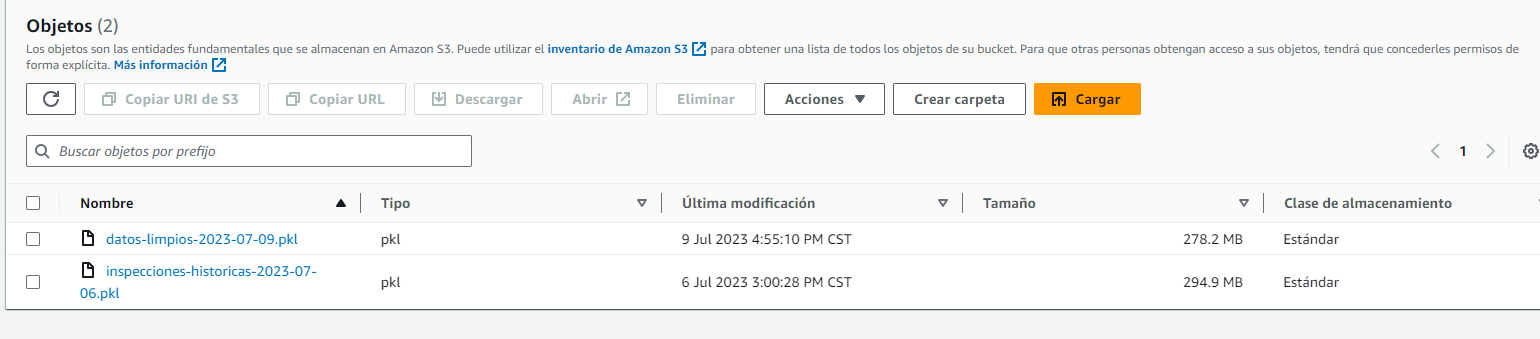

In [31]:
key = "datos-limpios-" + hoy + '.pkl'
pickle.dump(df, open(key,'wb')) 